# 🎬 Movie Recommendation with Milvus & Hugging Face

**Author:** Mohammad Sefidgar  

This notebook demonstrates how to build a **semantic movie recommendation system** using:

- 🤗 Hugging Face open-source embedding models
- 🧠 Milvus (vector database)
- 🎥 Netflix movie metadata

It includes:
- Vector similarity search
- Metadata filtering
- Embedding visualization (PCA)
- Hybrid keyword + vector search
- Human-readable recommendation explanations

**No API keys required. Fully open-source. Designed for Google Colab.**

## 1️⃣ Install Dependencies

Restart runtime after installation.

In [4]:
!pip install pymilvus datasets tqdm sentence-transformers scikit-learn numpy pymilvus[milvus_lite]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.3/55.3 MB 15.0 MB/s eta 0:00:00


## 2️⃣ Load Hugging Face Embedding Model

In [5]:
from sentence_transformers import SentenceTransformer

embedding_model = SentenceTransformer(
    "sentence-transformers/all-MiniLM-L6-v2"
)

DIMENSION = 384

## 3️⃣ Connect to Milvus (Milvus Lite)

In [6]:
from pymilvus import MilvusClient, DataType

COLLECTION_NAME = "movie_search"
BATCH_SIZE = 512

client = MilvusClient("./milvus_demo.db")

if client.has_collection(COLLECTION_NAME):
    client.drop_collection(COLLECTION_NAME)

## 4️⃣ Create Collection Schema

In [7]:
schema = MilvusClient.create_schema(
    auto_id=True,
    enable_dynamic_field=False,
)

schema.add_field("id", DataType.INT64, is_primary=True)
schema.add_field("title", DataType.VARCHAR, max_length=64000)
schema.add_field("type", DataType.VARCHAR, max_length=64000)
schema.add_field("release_year", DataType.INT64)
schema.add_field("rating", DataType.VARCHAR, max_length=64000)
schema.add_field("description", DataType.VARCHAR, max_length=64000)
schema.add_field("embedding", DataType.FLOAT_VECTOR, dim=DIMENSION)

client.create_collection(COLLECTION_NAME, schema=schema)

## 5️⃣ Create Index

In [8]:
index_params = client.prepare_index_params()

index_params.add_index(
    field_name="embedding",
    metric_type="IP",
    index_type="AUTOINDEX",
    params={},
)

client.create_index(COLLECTION_NAME, index_params)
client.load_collection(COLLECTION_NAME)

## 6️⃣ Load Dataset

In [10]:
from datasets import load_dataset

dataset = load_dataset(
    "hugginglearners/netflix-shows",
    split="train",
)

len(dataset)

8807

## 7️⃣ Embedding Function

In [11]:
def emb_texts(texts):
    return embedding_model.encode(
        texts,
        batch_size=64,
        normalize_embeddings=True,
        show_progress_bar=False,
    ).tolist()

## 8️⃣ Insert Data into Milvus

In [12]:
from tqdm import tqdm

batch = []

for i in tqdm(range(len(dataset))):
    batch.append(
        {
            "title": dataset[i]["title"] or "",
            "type": dataset[i]["type"] or "",
            "release_year": dataset[i]["release_year"] or -1,
            "rating": dataset[i]["rating"] or "",
            "description": dataset[i]["description"] or "",
        }
    )

    if len(batch) >= BATCH_SIZE or i == len(dataset) - 1:
        embeddings = emb_texts([item["description"] for item in batch])

        for item, emb in zip(batch, embeddings):
            item["embedding"] = emb

        client.insert(COLLECTION_NAME, batch)
        batch = []

100%|██████████| 8807/8807 [00:14<00:00, 602.57it/s]


## 9️⃣ Embedding Visualization (PCA)

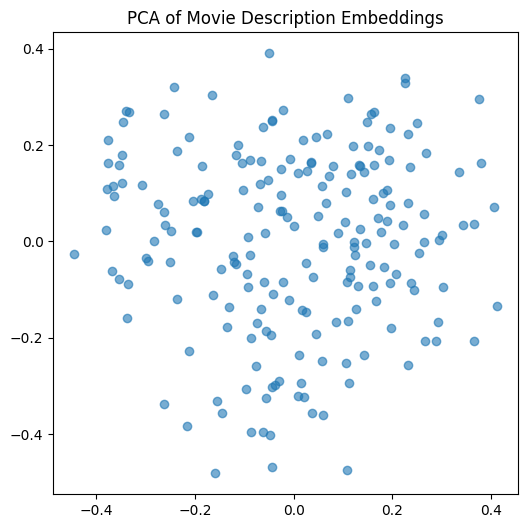

In [13]:
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

sample_texts = [dataset[i]["description"] for i in range(200)]
embs = np.array(emb_texts(sample_texts))

pca = PCA(n_components=2)
reduced = pca.fit_transform(embs)

plt.figure(figsize=(6,6))
plt.scatter(reduced[:,0], reduced[:,1], alpha=0.6)
plt.title("PCA of Movie Description Embeddings")
plt.show()

## 🔟 Vector Search Query

In [14]:
import textwrap

def vector_query(text, expr, top_k=5):
    res = client.search(
        collection_name=COLLECTION_NAME,
        data=emb_texts([text]),
        filter=expr,
        limit=top_k,
        output_fields=["title", "release_year", "rating", "description"],
        search_params={"metric_type": "IP", "params": {}},
    )

    return res[0]

## 1️⃣1️⃣ Hybrid Search (Keyword + Vector)

In [15]:
def hybrid_search(query_text, keyword, expr):
    vector_results = vector_query(query_text, expr, top_k=10)

    reranked = []
    for hit in vector_results:
        score = hit['distance']
        if keyword.lower() in hit['entity']['description'].lower():
            score += 0.1  # keyword boost
        reranked.append((score, hit))

    reranked.sort(key=lambda x: x[0], reverse=True)
    return [h for _, h in reranked[:5]]

## 1️⃣2️⃣ Recommendation Explanation

In [16]:
def explain_recommendation(query, movie):
    return (
        f"'{movie['title']}' was recommended because its storyline closely "
        f"matches your interest in '{query}'. The movie shares similar themes "
        f"and narrative elements found in the description."
    )

## 🎯 Final Example

In [18]:
query_text = "movie about a fluffy animal"
expr = 'release_year < 2019 and rating like "PG%"'

results = hybrid_search(query_text, "animal", expr)

for i, hit in enumerate(results, 1):
    movie = hit['entity']
    print(f"Rank {i}: {movie['title']} ({movie['release_year']})")
    print(explain_recommendation(query_text, movie))
    print()

Rank 1: Cats & Dogs: The Revenge of Kitty Galore (2010)
'Cats & Dogs: The Revenge of Kitty Galore' was recommended because its storyline closely matches your interest in 'movie about a fluffy animal'. The movie shares similar themes and narrative elements found in the description.

Rank 2: Puss in Boots (2011)
'Puss in Boots' was recommended because its storyline closely matches your interest in 'movie about a fluffy animal'. The movie shares similar themes and narrative elements found in the description.

Rank 3: Show Dogs (2018)
'Show Dogs' was recommended because its storyline closely matches your interest in 'movie about a fluffy animal'. The movie shares similar themes and narrative elements found in the description.

Rank 4: Mr. Peabody & Sherman (2014)
'Mr. Peabody & Sherman' was recommended because its storyline closely matches your interest in 'movie about a fluffy animal'. The movie shares similar themes and narrative elements found in the description.

Rank 5: Rango (2011)
'